In [1]:
%matplotlib inline

import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model, decomposition
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn_pandas import DataFrameMapper
import warnings
import skimage
from skimage import io, transform

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## Find the minimal dimensions

In [2]:
from glob import glob

min_x = (float('Inf'), float('Inf'))
min_y = (float('Inf'), float('Inf'))

for image in glob('./shirts/*/*'):
    shape = io.imread(image).shape
    if shape[0] < min_x[0]:
        min_x = shape
    if shape[1] < min_y[1]:
        min_y = shape

print(min_x)
print(min_y)

(70, 85, 3)
(70, 52, 3)


## Let's go with 70x70 as a starting point, then?

In [3]:
NEW_SIZE = (70, 70, 3)
all_shirts = io.imread_collection('./shirts/*/*')

resized_images = []

for image in all_shirts:
#     io.imshow_collection([image, transform.resize(image, NEW_SIZE)])
    resized_images.append(transform.resize(image, NEW_SIZE))
    
resized_array = np.array(resized_images)
del(resized_images)

## Center the images

In [4]:
image_mean = np.mean(resized_array, axis=0)
centered_array = resized_array - image_mean
np.mean(centered_array)

-7.9573281031074562e-17

## Reshape for PCA

In [5]:
reshaped_array = centered_array.reshape(centered_array.shape[0], np.product(centered_array.shape[1:]))

## PCA

In [6]:
pca = decomposition.PCA(whiten=True, copy=True)
pca.fit(reshaped_array)
diffs = np.ediff1d(pca.explained_variance_ratio_)

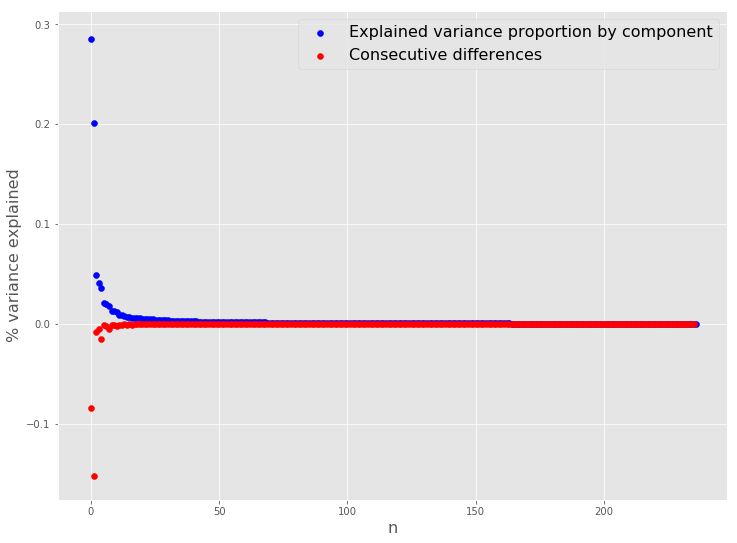

In [7]:
plt.figure(figsize=(12, 9))

plt.scatter(list(range(pca.explained_variance_ratio_.shape[0])), pca.explained_variance_ratio_, 
    color='blue', label='Explained variance proportion by component')

plt.scatter(list(range(diffs.shape[0])), diffs, 
    color='red', label='Consecutive differences')

plt.legend(loc=1, fontsize=16)
plt.xlabel(r'n', size=16)
plt.ylabel(r'% variance explained', size=16)
plt.show()

## Plot only for the first ~15

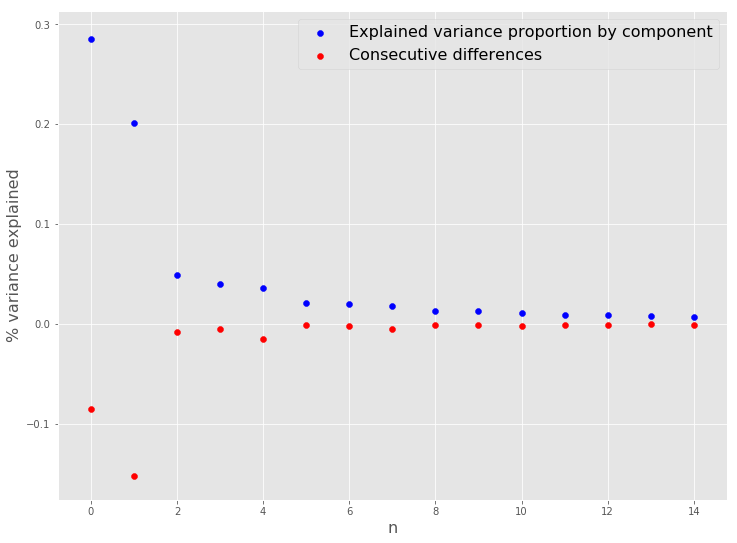

In [8]:
plt.figure(figsize=(12, 9))

NUM_ITEMS = 15

plt.scatter(list(range(NUM_ITEMS)), pca.explained_variance_ratio_[:NUM_ITEMS], 
    color='blue', label='Explained variance proportion by component')

plt.scatter(list(range(NUM_ITEMS)), diffs[:NUM_ITEMS], 
    color='red', label='Consecutive differences')

plt.legend(loc=1, fontsize=16)
plt.xlabel(r'n', size=16)
plt.ylabel(r'% variance explained', size=16)
plt.show()

## Looks like the first 5 principle components actually explain most of the variance

In [9]:
pca_top_5 = decomposition.PCA(n_components=5, whiten=True, copy=True)
transformed = pca_top_5.fit_transform(reshaped_array)

## Let's find the images most represented by each principle component

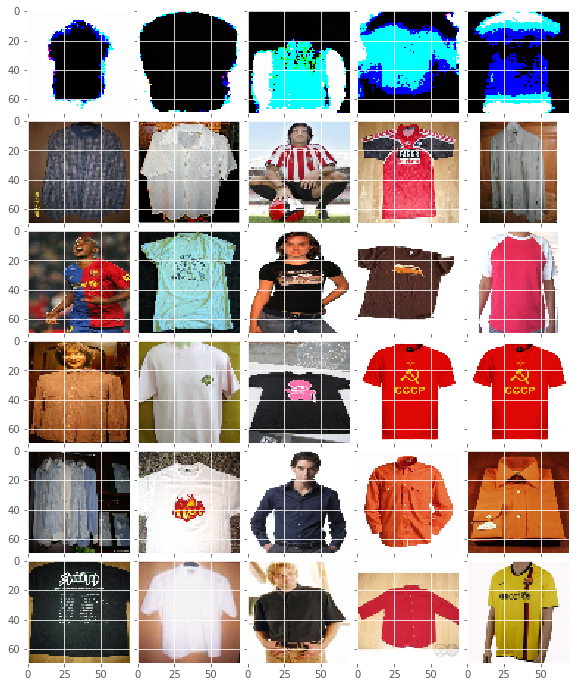

In [10]:
from mpl_toolkits.axes_grid1 import ImageGrid


components = pca_top_5.components_.copy()
components = [np.reshape(component, NEW_SIZE) for component in pca_top_5.components_]

fig = plt.figure(1, (10, 12))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(6, 5),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for i in range(5):
    grid[i].imshow(components[i])  # The AxesGrid object work as a list of axes.
    
for i, component in enumerate(pca_top_5.components_):
    top_five_indices = np.argpartition(reshaped_array.dot(component), -5)[-5:]
    top_five_images = np.take(resized_array, top_five_indices, axis=0)
    for j in range(5):
        grid[i + 5 * (j + 1)].imshow(top_five_images[j])
    

plt.show()


# Let's do some LDA instead

## Start by reloading the images by class

In [30]:
NEW_SIZE = (100, 100, 3)
formal_shirts = io.imread_collection('./shirts/formal_shirts/*')
shirts_and_jerseys = io.imread_collection('./shirts/shirts_and_jerseys/*')

resized_formal = []
for image in formal_shirts:
    resized_formal.append(transform.resize(image, NEW_SIZE))

n_formal = len(resized_formal)
    
resized_shirts = []
for image in shirts_and_jerseys:
    resized_shirts.append(transform.resize(image, NEW_SIZE))

n_jerseys = len(resized_shirts)

resized_combined = np.concatenate((np.array(resized_formal), np.array(resized_shirts)))
del(resized_formal)
del(resized_shirts)

## Center and reshape

In [31]:
image_mean = np.mean(resized_combined, axis=0)
centered_combined = resized_combined - image_mean
reshaped_combined = centered_combined.reshape(centered_combined.shape[0], np.product(centered_combined.shape[1:]))

## Split train-test to be able to assess classification accuracy

In [32]:
from sklearn.model_selection import train_test_split

classes = [1] * n_formal + [0] * n_jerseys
X_train, X_test, y_train, y_test = train_test_split(reshaped_combined, classes, test_size=0.15, 
                                                    stratify=classes, random_state=RANDOM_SEED) 

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train, y_train)
print('Train accuracy:', sum(lda.predict(X_train) == y_train) / X_train.shape[0])
print('Test accuracy:', sum(lda.predict(X_test) == y_test) / X_test.shape[0])

/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Train accuracy: 0.885572139303
Test accuracy: 0.75
